In [4]:
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import openai
import re
import time
from azure.storage.blob import BlobServiceClient
#import fitz 
#from docx import Document
import pytesseract
from PIL import Image
import io
from azure.cosmos import CosmosClient, exceptions
import argparse
import pdfplumber
import io
import os
import logging
from pydantic import BaseModel
from langgraph.graph import StateGraph
import random
from typing import Literal
from langgraph.graph import START, END
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from sentence_transformers import SentenceTransformer
#from annoy import AnnoyIndex
import faiss
from typing import Optional, Annotated, Dict, Any, List, Union
from typing_extensions import Annotated
from pathlib import Path
import glob
import math
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from openai import AzureOpenAI
import json
import logging
from datetime import datetime, timedelta
import sys
import os

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)

from settings.config import AZURE_OPEN_AI_SPEACH, AZURE_OPEN_AI_AUTOMATIZACION,AZURE_OPEN_AI_SEARCH,AZURE_OPEN_AI_SEARCH_RESOLUCION,AZURE_OPEN_AI_SEARCH_NORMATIVA

#### Modelo de embeddings

In [5]:
nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')
stop_words = set(stopwords.words('spanish'))
palabras_irrelevantes = {'cordoba', 'distrital', 'solicitud', 'petición', 'ciudad', 'fiscalizacion'}  #Palabras sin significado clave
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("spanish"))
#nlp = spacy.load("es_core_news_sm")  #Modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")  #Modelo de spaCy para español

nltk.download('wordnet')
nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')

#Inicializar el modelo de embeddings
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

#Entidades de referencia y convertimos a tipo float32 para FAISS
entidades = ["Fiscalización caso 1", "Fiscalización caso 2", "Fiscalización caso 3", "Fiscalización caso 4"]
categoria_embeddings = embedding_model.encode(entidades)
categoria_embeddings = np.array(categoria_embeddings).astype('float32')

d = categoria_embeddings.shape[1]  #Dimensión de los embeddings
faiss_index = faiss.IndexFlatL2(d)  #Índice L2 (distancia euclidiana)
faiss_index.add(categoria_embeddings)  #Agregar los embeddings al índice

faiss.write_index(faiss_index, "faiss_index.bin")

#Credenciales OpenAI:
openai.api_type = "azure"
openai.api_base = "https://ai-danielvallejosai0530531063088720.openai.azure.com/"
openai.api_version = "2024-12-01-preview"
openai.api_key = AZURE_OPEN_AI_SPEACH

embedding_deployment_name = "text-embedding-3-large"
embedding_api_version = "2023-05-15"
chat_deployment_name = "gpt-4.1"

client = openai.AzureOpenAI(  #AzureOpenAI en lugar de Client
api_key=AZURE_OPEN_AI_SPEACH,
azure_endpoint="https://ai-danielvallejosai0530531063088720.openai.azure.com/",
api_version="2024-12-01-preview")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rayespinoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rayespinoza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rayespinoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Funciones & Accesos:

In [6]:
#Text:
def leer_archivos_txt_a_dataframe(ruta_base, incluir_subcarpetas=True, guardar_csv=True):    
    
    ruta_base = Path(ruta_base)
    datos = []
    
    if incluir_subcarpetas:
        patron = "**/*.txt"  
    else:
        patron = "*.txt"  
    
    archivos_txt = list(ruta_base.glob(patron))

    if not archivos_txt:
        print("No se encontraron archivos TXT en la ruta especificada")
        return pd.DataFrame(columns=['Case', 'Description'])
    
    for i, archivo in enumerate(archivos_txt, 1):
        try:
            print(f"Procesando {i}/{len(archivos_txt)}: {archivo.name}")
            
            with open(archivo, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            nombre_caso = archivo.stem
            
            datos.append({
                'Case': nombre_caso,
                'Description': contenido
            })
            
            print(f"Leído exitosamente ({len(contenido)} caracteres)")
            
        except Exception as e:
            print(f"Error leyendo {archivo.name}: {str(e)}")

            datos.append({
                'Case': archivo.stem,
                'Description': f"ERROR AL LEER ARCHIVO: {str(e)}"
            })
    
    df = pd.DataFrame(datos)
        
    if not df.empty:
        df_clean = df[~df['Description'].str.startswith('ERROR', na=False)]
        if not df_clean.empty:
            print(f"Promedio de caracteres por descripción: {df_clean['Description'].str.len().mean():.0f}")
            print(f"Descripción más larga: {df_clean['Description'].str.len().max()} caracteres")
            print(f"Descripción más corta: {df_clean['Description'].str.len().min()} caracteres")
    
    return df

In [7]:
def get_openai_client():
    openai.api_type = "azure"
    openai.api_base = "https://ai-danielvallejosai0530531063088720.openai.azure.com/"
    openai.api_version = "2024-12-01-preview"
    openai.api_key = AZURE_OPEN_AI_SPEACH
    
    client = openai.AzureOpenAI(
        api_key=AZURE_OPEN_AI_SPEACH,
        azure_endpoint="https://ai-danielvallejosai0530531063088720.openai.azure.com/",
        api_version="2024-12-01-preview"
    )
    
    return client, {
        "embedding_deployment_name": "text-embedding-3-large",
        "embedding_api_version": "2023-05-15",
        "chat_deployment_name": "gpt-4.1"
    }

### Sistema Multiagente - LangGraph

In [8]:

####===============START: PROCESO CON AI SEARCH ===================
# Configuración de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
# =============================================================================
# DATACLASSES Y MODELOS DE DATOS
# =============================================================================

@dataclass
class DatosCorridaVista:
    """Estructura de datos extraídos de la corrida de vista"""
    contribuyente: str
    cuit: str
    tributo: str
    periodos_fiscales: List[str]
    actividad_codificada: str
    normativa_aplicada: List[str]
    motivo_del_ajuste: str
    infraccion_detectada: str
    multa_estimativa: str
    recargos_resarcitorios: str
    plazo_para_descargo: int
    canal_presentacion: str
    requisitos_para_justificar: List[str]
    documentos_adicionales_mencionados: List[str]

@dataclass
class ResultadoValidacion:
    """Resultado de la validación de cumplimiento"""
    cumplimiento_general: str  # "cumple", "parcial", "no_cumple"
    detalles_por_requisito: List[Dict]
    recomendacion_resolucion: str
    fundamentos_juridicos: List[str]

####===============START: BASE MODEL LANGGRAPH ===================
class GraphState(BaseModel):
    graph_nropeticion: Optional[str] = ""
    graph_contexto: Optional[str] = ""
    graph_state: Optional[str] = ""
    graph_clasificacionIni: Optional[str] = ""
    graph_normalizacion: Optional[str] = ""
    graph_similitud_coseno: Optional[str] = ""
    graph_summarize_pqrs: Optional[str] = ""
    
    graph_corrida_vistas: Optional[str] = ""
    graph_analisis_descargo: Optional[str] = ""
    graph_clasificatorio_impugnacion: Optional[str] = ""
    graph_consultar_norma: Optional[str] = ""
    graph_decision_final: Optional[str] = ""
    
    # Nuevos estados para el sistema integrado
    graph_query_text: Optional[str] = ""
    graph_ruta_carpetas: Optional[Dict[str, Union[str, List[str]]]] = ""
    graph_ruta_archivos: Optional[Dict[str, Union[str, List[str]]]] = ""
    graph_datos_corrida: Optional[Dict] = None
    graph_hechos_extraidos: Optional[Dict] = None
    graph_jurisprudencia: Optional[Dict] = None
    graph_validacion_final: Optional[Dict] = None
    graph_resolucion_generada: Optional[str] = None
    graph_resultado_sistema_automizacion: Optional[str] = "" 


class SistemaAutomatizacionDO:
    """Sistema principal para automatización de Determinación de Oficio"""
    
    def __init__(self):
        # Configuración Azure OpenAI
        self.openai_client = AzureOpenAI(
            api_key=AZURE_OPEN_AI_AUTOMATIZACION,
            azure_endpoint="https://openiamicro.openai.azure.com",
            api_version="2025-01-01-preview"
        )
        
        # Configuración Azure Search
        self.search_client = SearchClient(
            endpoint="https://aisearch-paolocetti.search.windows.net",
            index_name="cbaanalisis",
            credential=AzureKeyCredential(AZURE_OPEN_AI_SEARCH)
        )
        self.norma_clients = {
            "codigo_tributario": SearchClient(endpoint="https://aisearch-paolocetti.search.windows.net",
                                  index_name="codigo_tributario",
                          credential=AzureKeyCredential(AZURE_OPEN_AI_SEARCH)),
            "jurisprudencia": SearchClient(endpoint="https://aisearch-paolocetti.search.windows.net",
                                  index_name="cbaanalisis",
                          credential=AzureKeyCredential(AZURE_OPEN_AI_SEARCH)),
            "resolucion_normativa": SearchClient(endpoint="https://search-caba-poc-eastus-001.search.windows.net",
                                         index_name="resolucion_normativa",
                                 credential=AzureKeyCredential(AZURE_OPEN_AI_SEARCH_RESOLUCION)),
            "decreto_reglamentario": SearchClient(endpoint="https://search-caba-poc-eastus-001.search.windows.net",
                             index_name="decreto_reglamentario",
                             credential=AzureKeyCredential(AZURE_OPEN_AI_SEARCH_RESOLUCION))
        }
        
        # Cargar base de conocimiento normativo
        self.normativa_base = self._cargar_normativa_base()
        
    def buscar_normativa_multindice(self, query: str, k: int = 3) -> List[Dict]:
        """Busca en los tres índices legislativos y devuelve los k mejores resultados globales"""
        hits = []
        for nombre, client in self.norma_clients.items():
            try:
                results = client.search(search_text=query, top=k)
                for r in results:
                    hits.append({
                        "articulo": r.get("articulo", ""),
                        "texto": r.get("texto", "")[:600],      # recortamos
                        "score": r.get("@search.score", 0)
                    })
            except Exception as e:
                logger.warning(f"Búsqueda falló en {nombre}: {e}")
                    
        # ordenar por score descendente y quedarnos con los k mejores globales
        hits = sorted(hits, key=lambda x: x["score"], reverse=True)[:k]
        return hits
    
    def _buscar_normativa_relevante(self, normas: List[str], requisitos: List[str]) -> List[Dict]:
        """Busca artículos normativos relevantes desde los índices vectoriales usando Azure AI Search"""
        index_names = ["resolucion_normativa", "decreto_reglamentario", "codigo_tributario"]
        normativa_encontrada = []
        
        for index_name in index_names:
            client = SearchClient(
            endpoint="https://search-caba-poc-eastus-001.search.windows.net",
            index_name=index_name,
            credential=AzureKeyCredential(AZURE_OPEN_AI_SEARCH_NORMATIVA)
            )
            
            for criterio in normas + requisitos:
                results = client.search(
                search_text=criterio,
                top=2,
                search_fields=["texto", "articulo"]
            )
                for result in results:
                    normativa_encontrada.append({
                    "articulo": result.get("articulo", ""),
                    "texto": result.get("texto", ""),
                    "score": result.get("@search.score", 0),
                    "fuente": index_name
                })
        print(normativa_encontrada)
        return normativa_encontrada
        
    def _cargar_normativa_base(self) -> Dict:
        """Carga la base de conocimiento normativo"""
        return {
            "codigo_tributario": {
                "ley": "Ley Provincial N° 6006",
                "articulos_clave": ["Art. 12", "Art. 15", "Art. 67", "Art. 89"],
                "infracciones": {
                    "omision": "Art. 67",
                    "defraudacion": "Art. 89",
                    "resistencia": "Art. 95"
                }
            },
            "procedimiento_fiscal": {
                "plazos": {
                    "descargo": 15,
                    "recurso": 15,
                    "reconsideracion": 30
                },
                "notificaciones": "DFE obligatorio"
            },
            "principios_constitucionales": [
                "Legalidad (Art. 19 C.N.)",
                "Propiedad - No confiscatoriedad (Art. 17 C.N.)",
                "Igualdad (Art. 16 C.N.)",
                "Debido proceso adjetivo"
            ]
        }

    def extraer_datos_corrida_vista(self, texto: str) -> DatosCorridaVista:
        """Extrae y estructura datos de la corrida de vista con validación normativa"""
        
        with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classification/service/prompt/automization/prompt_corrida_vista.txt', 'r', encoding='utf-8') as file:
            PROMPT_TEMPLATE_CORRIDA_VISTA = file.read()

        prompt = PROMPT_TEMPLATE_CORRIDA_VISTA.format(
                texto_pqrs=texto
            )
        
        try:
            response = self.openai_client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[{"role": "system", "content": prompt}],
                temperature=0.1
            )
            print(response.choices[0].message.content.strip())
            raw_response_content = response.choices[0].message.content.strip()
            # Elimina las comillas triples y la palabra "json" si existen
            if raw_response_content.startswith("```json"):
                json_string = raw_response_content[len("```json"):].strip()
                if json_string.endswith("```"):
                    json_string = json_string[:-len("```")].strip()
            else:
                json_string = raw_response_content
            
            datos_json = json.loads(json_string)
            print(datos_json)
            
            return DatosCorridaVista(
                contribuyente=datos_json.get('contribuyente', ''),
                cuit=datos_json.get('cuit', ''),
                tributo=datos_json.get('tributo', ''),
                periodos_fiscales=datos_json.get('periodos_fiscales', []),
                actividad_codificada=datos_json.get('actividad_codificada', ''),
                normativa_aplicada=datos_json.get('normativa_aplicada', []),
                motivo_del_ajuste=datos_json.get('motivo_del_ajuste', ''),
                infraccion_detectada=datos_json.get('infraccion_detectada', ''),
                multa_estimativa=datos_json.get('multa_estimativa', ''),
                recargos_resarcitorios=datos_json.get('recargos_resarcitorios', ''),
                plazo_para_descargo=datos_json.get('plazo_para_descargo', 15),
                canal_presentacion=datos_json.get('canal_presentacion', ''),
                requisitos_para_justificar=datos_json.get('requisitos_para_justificar', []),
                documentos_adicionales_mencionados=datos_json.get('documentos_adicionales_mencionados', [])
            )
            
        except Exception as e:
            logger.error(f"Error al extraer datos de corrida de vista: {e}")
            raise

    def clasificar_impugnacion_avanzada(self, textos_descargo: List[str]) -> Dict:
        """Clasificación mejorada con análisis jurídico profundo"""
        
        texto_completo = " ".join(textos_descargo)
        
        with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classification/service/prompt/automization/prompt_clasificar_impugnacion.txt', 'r', encoding='utf-8') as file:
            PROMPT_TEMPLATE_CLASIFICAR_IMPUGNACION = file.read()

        prompt = PROMPT_TEMPLATE_CLASIFICAR_IMPUGNACION.format(
                normativa_base=json.dumps(self.normativa_base, indent=2, ensure_ascii=False),
                texto_completo_pqrs=texto_completo
            )
        
        try:
            response = self.openai_client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[{"role": "system", "content": prompt}],
                temperature=0.1
            )
            
            raw_response_content = response.choices[0].message.content.strip()
            # Elimina las comillas triples y la palabra "json" si existen
            if raw_response_content.startswith("```json"):
                json_string = raw_response_content[len("```json"):].strip()
                if json_string.endswith("```"):
                    json_string = json_string[:-len("```")].strip()
            else:
                json_string = raw_response_content
                
            print(json_string)
            
            
            return json.loads(json_string)
            
        except Exception as e:
            logger.error(f"Error en clasificación avanzada: {e}")
            raise

    def extraer_hechos_estructurados(self, textos_descargo: List[str]) -> Dict:
        """Extrae hechos con análisis de relevancia jurídica"""
        
        texto_completo = " ".join(textos_descargo)
        
        with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classification/service/prompt/automization/prompt_hechos_estructurado.txt', 'r', encoding='utf-8') as file:
            PROMPT_TEMPLATE_HECHOS_ESTRUCTURADO = file.read()

        prompt = PROMPT_TEMPLATE_HECHOS_ESTRUCTURADO.format(
                texto_completo_pqrs=texto_completo
            )
        
        try:
            response = self.openai_client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[{"role": "system", "content": prompt}],
                temperature=0.1
            )
            
            raw_response_content = response.choices[0].message.content.strip()
            # Elimina las comillas triples y la palabra "json" si existen
            if raw_response_content.startswith("```json"):
                json_string = raw_response_content[len("```json"):].strip()
                if json_string.endswith("```"):
                    json_string = json_string[:-len("```")].strip()
            else:
                json_string = raw_response_content
            
            return json.loads(json_string)
            
        except Exception as e:
            logger.error(f"Error en extracción de hechos: {e}")
            raise

    def buscar_jurisprudencia_contextual(self, clasificacion: Dict, hechos: Dict) -> Dict:
        """Búsqueda de jurisprudencia contextualizada y relevante"""
        
        # Construir query semántica basada en clasificación y hechos
        queries = []
        
        for clasificacion_item in clasificacion.get('clasificaciones', []):
            tipo = clasificacion_item.get('tipo', '')
            subtipo = clasificacion_item.get('subtipo', '')
            queries.append(f"{tipo} {subtipo}")
        
        # Agregar hechos relevantes para búsqueda
        hechos_relevantes = [
            h['descripcion'] for h in hechos.get('hechos', [])
            if h.get('relevancia_juridica') == 'alta'
        ]
        
        jurisprudencia_encontrada = []
        
        for query in queries[:3]:  # Limitar búsquedas
            try:
                results = self.search_client.search(
                    search_text=query,
                    top=3
                   
                    
                )
                
                for result in results:
                    jurisprudencia_encontrada.append({
                        'tipo': result.get('tipo', ''),
                        'agravio': result.get('agravio', ''),
                        'respuesta': result.get('respuesta', '')[:500],  # Limitar texto
                        'relevancia': result.get('@search.score', 0),
                        'query_origen': query
                    })
                    
            except Exception as e:
                logger.warning(f"Error en búsqueda de jurisprudencia para query '{query}': {e}")
        
        return {
            'jurisprudencia': jurisprudencia_encontrada,
            'total_encontrados': len(jurisprudencia_encontrada),
            'queries_utilizadas': queries
        }
        
   


    def validar_cumplimiento_avanzado(self, 
                                     datos_corrida: DatosCorridaVista,
                                     clasificacion: Dict,
                                     hechos: Dict,
                                     jurisprudencia: Dict,
                                     normativa_relevante: List[Dict]) -> ResultadoValidacion:
        """Validación integral con análisis jurisprudencial"""
        print("Iniciar Validar cumplimiento avanzado")
        norma_chunks = self.buscar_normativa_multindice(
            query=" ".join(datos_corrida.normativa_aplicada + 
            [c['subtipo'] for c in clasificacion.get('clasificaciones', [])[:1]])
        )
        logger.info(f"Normativa añadida al prompt: {len(norma_chunks)} chunks")
        normativa_json = json.dumps(norma_chunks, indent=2, ensure_ascii=False)
        
        with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classification/service/prompt/automization/prompt_validar_cumplimiento.txt', 'r', encoding='utf-8') as file:
            PROMPT_TEMPLATE_VALIDAR_CUMPLIMIENTO = file.read()

        prompt = PROMPT_TEMPLATE_VALIDAR_CUMPLIMIENTO.format(
                datos_corrida_contribuyente=datos_corrida.contribuyente,
                datos_corrida_cuit=datos_corrida.cuit,
                datos_corrida_tributo=datos_corrida.tributo,
                requisitos_cumplir=json.dumps(datos_corrida.requisitos_para_justificar, ensure_ascii=False),
                normativa_aplicada=json.dumps(datos_corrida.normativa_aplicada, ensure_ascii=False),
                impugnaciones_clasificadas=json.dumps(clasificacion, indent=2, ensure_ascii=False),
                hechos_extraidos=json.dumps(hechos, indent=2, ensure_ascii=False),
                jurisprudencia_relevante=json.dumps(jurisprudencia, indent=2, ensure_ascii=False),
                normativa_relevante_pqrs=normativa_relevante
            )
        
        try:
            response = self.openai_client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[{"role": "system", "content": prompt}],
                temperature=0.1
            )
            raw_response_content = response.choices[0].message.content.strip()
            # Elimina las comillas triples y la palabra "json" si existen
            if raw_response_content.startswith("```json"):
                json_string = raw_response_content[len("```json"):].strip()
                if json_string.endswith("```"):
                    json_string = json_string[:-len("```")].strip()
            else:
                json_string = raw_response_content
            resultado = json.loads(json_string)
            
            return ResultadoValidacion(
                cumplimiento_general=resultado.get('cumplimiento_general', 'no_cumple'),
                detalles_por_requisito=resultado.get('evaluacion_por_requisito', []),
                recomendacion_resolucion=resultado.get('recomendacion_resolucion', ''),
                fundamentos_juridicos=resultado.get('fundamentos_principales', [])
            )
            
        except Exception as e:
            logger.error(f"Error en validación avanzada: {e}")
            raise

    def generar_resolucion_estructurada(self, 
                                       datos_corrida: DatosCorridaVista,
                                       validacion: ResultadoValidacion,
                                       tipo_resolucion: str = "determinativa") -> str:
        """Genera resolución siguiendo plantillas oficiales"""
        
        plantillas = {
            "determinativa": {
                "estructura": ["VISTOS", "RESULTANDO", "CONSIDERANDO", "RESUELVE"],
                "formato": "Resolución Determinativa N° XXX/2025"
            },
            "reconsideracion": {
                "estructura": ["VISTOS", "RESULTANDO", "CONSIDERANDO", "RESUELVE"],
                "formato": "Resolución de Reconsideración N° XXX/2025"
            }
        }
        
        plantilla = plantillas.get(tipo_resolucion, plantillas["determinativa"])
        
        with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classification/service/prompt/automization/prompt_generar_resolucion.txt', 'r', encoding='utf-8') as file:
            PROMPT_TEMPLATE_GENERAR_RESOLUCION = file.read()

        prompt = PROMPT_TEMPLATE_GENERAR_RESOLUCION.format(
                plantilla_formato=plantilla['formato'],
                datos_expediente=json.dumps(datos_corrida.__dict__, indent=2, ensure_ascii=False),
                resultado_evaluacion=json.dumps(validacion.__dict__, indent=2, ensure_ascii=False),
                plantilla_estructura=plantilla['estructura']
            )
        
        try:
            response = self.openai_client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[{"role": "system", "content": prompt}],
                temperature=0.1,
                max_tokens=4000
            )
            
            return response.choices[0].message.content.strip()
            
        except Exception as e:
            logger.error(f"Error al generar resolución: {e}")
            raise

    def procesar_caso_completo(self, 
                              texto_corrida: str,
                              textos_descargo: List[str],
                              tipo_resolucion: str = "determinativa") -> Dict:
        """Procesamiento completo de un caso de DO"""
        
        logger.info("Iniciando procesamiento completo del caso")
        
        try:
            # 1. Extraer datos de corrida de vista
            datos_corrida = self.extraer_datos_corrida_vista(texto_corrida)
            logger.info(f"Datos extraídos para {datos_corrida.contribuyente}")
            
            # 2. Clasificar impugnaciones
            clasificacion = self.clasificar_impugnacion_avanzada(textos_descargo)
            logger.info(f"Impugnaciones clasificadas: {len(clasificacion.get('clasificaciones', []))}")
            
            # 3. Extraer hechos
            hechos = self.extraer_hechos_estructurados(textos_descargo)
            logger.info(f"Hechos extraídos: {len(hechos.get('hechos', []))}")
            
            # 4. Buscar jurisprudencia
            jurisprudencia = self.buscar_jurisprudencia_contextual(clasificacion, hechos)
            logger.info(f"Jurisprudencia encontrada: {jurisprudencia['total_encontrados']} resultados")
            
            normativa_relevante = self._buscar_normativa_relevante(
                normas=datos_corrida.normativa_aplicada,
                requisitos=datos_corrida.requisitos_para_justificar
            )

            # 5. Validar cumplimiento
            validacion = self.validar_cumplimiento_avanzado(
                datos_corrida, clasificacion, hechos, jurisprudencia, normativa_relevante
            )
            logger.info(f"Validación completada: {validacion.cumplimiento_general}")
            
            # 6. Generar resolución
            resolucion = self.generar_resolucion_estructurada(
                datos_corrida, validacion, tipo_resolucion
            )
            logger.info("Resolución generada exitosamente")
            
            return {
                "datos_corrida": datos_corrida.__dict__,
                "clasificacion": clasificacion,
                "hechos": hechos,
                "jurisprudencia": jurisprudencia,
                "validacion": validacion.__dict__,
                "resolucion": resolucion,
                "timestamp": datetime.now().isoformat(),
                "estado": "completado"
            }
            
        except Exception as e:
            logger.error(f"Error en procesamiento completo: {e}")
            return {
                "estado": "error",
                "mensaje": str(e),
                "timestamp": datetime.now().isoformat()
            }
    
####===============END: PROCESO CON AI SEARCH ===================


####=============== LANGGRAPH STATE MODELO ===================
#=============================================================================
#NODOS LANGGRAPH INTEGRADOS
#=============================================================================
#Instancia global del sistema (para uso en los nodos)
sistema_do = SistemaAutomatizacionDO()   

def greeting_node(state):
    #Iniciamos el modelo de GraphState:
    return {"graph_state": "Petición recibida"}

def peticion_node(state):
    #Solo modificamos graph_state:

    ruta_txt_aporte = state.graph_ruta_carpetas["aportes_carpeta"]
    ruta_txt_corrida = state.graph_ruta_carpetas["corrida_carpeta"]
    df_aporte = leer_archivos_txt_a_dataframe(
        ruta_base=ruta_txt_aporte,
        incluir_subcarpetas=False,
        guardar_csv=False
    )
    df_corrida = leer_archivos_txt_a_dataframe(
        ruta_base=ruta_txt_corrida,
        incluir_subcarpetas=False, 
        guardar_csv=False
    )
    df_caso1 = pd.concat([df_aporte, df_corrida], ignore_index=True)

    #Combine the DataFrames:
    text_columns = [col for col in df_caso1.columns if col.startswith('text')]

    if text_columns:
        query_text = ' '.join(df_caso1[text_columns].fillna('').astype(str).values.flatten())
    else:
        content_columns = [col for col in df_caso1.columns if col in ['contenido', 'texto', 'content', 'text']]
        
        if content_columns:
            query_text = ' '.join(df_caso1[content_columns].fillna('').astype(str).values.flatten())
        else:
            string_columns = df_caso1.select_dtypes(include=['object', 'string']).columns.tolist()
            query_text = ' '.join(df_caso1[string_columns].fillna('').astype(str).values.flatten())
    #Limpiar el texto:
    query_text = ' '.join(query_text.split())

    print(f"Query text generado con {len(query_text)} caracteres")
    print(f"Primeros 200 caracteres: {query_text[:200]}...")

    return {"graph_query_text": query_text}


def limpieza_normalizacion_node2(state):
    query_text=state.graph_query_text#graph_contexto

    texto = query_text.lower()
    texto = re.sub(r'\W', ' ', texto)
    texto = re.sub(r'\d+', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    #===>Tokenización y lematización
    palabras = texto.split()
    #palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras if palabra not in stop_words]
    palabras = [stemmer.stem(palabra) for palabra in palabras if palabra not in stop_words and palabra not in palabras_irrelevantes]  # Stemming
    texto_procesado = ' '.join(palabras)
    #===>Extracción de entidades nombradas (NER)
    doc = nlp(query_text)
    entidades = [ent.text for ent in doc.ents]
    #state.graph_normalizacion=texto_procesado
    return {"graph_normalizacion": texto_procesado}

def semantica_entidades_node3(state):
    
    #New:
    texto_procesado=state.graph_normalizacion
    #texto_procesado = datos["texto_procesado"]
    #Generar embedding del texto
    embedding = embedding_model.encode([texto_procesado])

    #Buscar en FAISS la categoría más cercana
    D, I = faiss_index.search(np.array(embedding).astype('float32'), k=3)  #Buscar top 3 entidades

    #Obtener las entidades
    entidades = ["Fiscalización caso 1", "Fiscalización caso 2", "Fiscalización caso 3", "Fiscalización caso 4"]
    entidades_similares = [entidades[i] for i in I[0]]

    #state.graph_similitud_coseno=entidades_similares
    return {"graph_similitud_coseno": entidades_similares}

def summarize_entidades_node4(state):
    
    #To sum up:
    query_text=state.graph_normalizacion

    client, config = get_openai_client()

    with open('/Users/rayespinoza/AI_Projects/fiscalizacion_classification/service/prompt/summary/prompt_summarize_en.txt', 'r', encoding='utf-8') as file:
        PROMPT_TEMPLATE_G = file.read()

    prompt = PROMPT_TEMPLATE_G.format(
            question=query_text
        )

    response = client.chat.completions.create(
                model=chat_deployment_name,
                messages=[
                    {"role": "system", "content": "Eres un experto en resumiendo solicitudes."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                top_p=1
            )

    resultado = response.choices[0].message.content.strip()

    return {"graph_summarize_pqrs": resultado}

def clasificacion_analisis_corrida_vista(state):
    
    query_text=state.graph_normalizacion
    resumen_pqrs=state.graph_summarize_pqrs
    entidades_coseno=state.graph_similitud_coseno

    resultado='aqui va el análisis de corrida vista'

    return {"graph_corrida_vistas": resultado}

def clasificacion_analisis_descargo(state):
    
    query_text=state.graph_normalizacion
    resumen_pqrs=state.graph_summarize_pqrs
    entidades_coseno=state.graph_similitud_coseno
    resultado='analisis de descargo'

    return {"graph_analisis_descargo": resultado}

def paso_clasificatorio_impugnacion(state):
    
    resultado = 'Paso clasificatorio impugnación'
    return {"graph_clasificatorio_impugnacion": resultado}

def paso_consultar_norma(state):
    
    query_text=state.graph_normalizacion
    resumen_pqrs=state.graph_summarize_pqrs
    entidades_coseno=state.graph_similitud_coseno
    resultados ='Consultar norma jurídica relacionada'

    return {"graph_consultar_norma": resultados}

def solicitud_decision_final(state):

    resultado = 'Decisión final de solicitud'
    return {"graph_decision_final": resultado}

def ejecutar_prueba_completa(state):
    rutas_archivos = state.graph_ruta_archivos

    try:
        #====> Leemos los archivos de entrada:
        with open(rutas_archivos["corrida"], "r", encoding="utf-8") as f:
            contenido_corrida = f.read()
        
        #Leer archivos de aportes
        contenidos_aportes = []
        for ruta in rutas_archivos["aportes"]:
            with open(ruta, "r", encoding="utf-8") as f:
                contenidos_aportes.append(f.read())
        
        # Procesar caso completo
        resultado = sistema_do.procesar_caso_completo(
            texto_corrida=contenido_corrida,
            textos_descargo=contenidos_aportes,
            tipo_resolucion="determinativa"
        )
        
        print("Procesamiento completado exitosamente")
        print(f"Estado: {resultado.get('estado')}")
        return {"graph_resultado_sistema_automizacion": resultado}
        
    except Exception as e:
        print(f"Error en la prueba: {e}")
        return {"graph_resultado_sistema_automizacion": None}

In [9]:
# Crear el grafo
graph = StateGraph(GraphState)
# Añadir nodos
graph.add_node("greeting_node", greeting_node)
graph.add_node("peticion_node", peticion_node)
graph.add_node("limpieza_normalizacion_node2", limpieza_normalizacion_node2)
graph.add_node("semantica_entidades_node3", semantica_entidades_node3)
graph.add_node("summarize_entidades_node4", summarize_entidades_node4)
graph.add_node("clasificacion_analisis_corrida_vista", clasificacion_analisis_corrida_vista)
graph.add_node("clasificacion_analisis_descargo", clasificacion_analisis_descargo)
graph.add_node("paso_clasificatorio_impugnacion", paso_clasificatorio_impugnacion)
#graph.add_node("paso_consultar_norma", paso_consultar_norma)
#graph.add_node("solicitud_decision_final", solicitud_decision_final)
graph.add_node("ejecutar_prueba_completa", ejecutar_prueba_completa)

# Añadir bordes
graph.add_edge(START, "greeting_node")
graph.add_edge("greeting_node", "peticion_node")
graph.add_edge("peticion_node", "limpieza_normalizacion_node2")
graph.add_edge("limpieza_normalizacion_node2", "semantica_entidades_node3")
graph.add_edge("semantica_entidades_node3", "summarize_entidades_node4")
#Analisis:
graph.add_edge("summarize_entidades_node4", "clasificacion_analisis_corrida_vista")
graph.add_edge("summarize_entidades_node4", "clasificacion_analisis_descargo")

#Salida Sectores
graph.add_edge("clasificacion_analisis_corrida_vista", "paso_clasificatorio_impugnacion")
graph.add_edge("clasificacion_analisis_descargo", "paso_clasificatorio_impugnacion")
graph.add_edge("paso_clasificatorio_impugnacion", "ejecutar_prueba_completa")
#graph.add_edge("paso_consultar_norma", "solicitud_decision_final")
#graph.add_edge("solicitud_decision_final", "ejecutar_prueba_completa")
#Final:
graph.add_edge("ejecutar_prueba_completa", END)

### Ejecución del modelo

In [10]:
graph_compiled = graph.compile()
numero = '1'

base_dict = {
    "graph_nropeticion": numero,
    "graph_ruta_archivos": {
        "corrida": "/Users/rayespinoza/AI_Projects/fiscalizacion_classification/data/casos/extract/Caso_1/corrida/caso1_corrida_de_vista-SD_extraido.txt",
        "aportes": [
            "/Users/rayespinoza/AI_Projects/fiscalizacion_classification/data/casos/extract/Caso_1/aporte/caso1_aporte_1-SD_extraido.txt",
            "/Users/rayespinoza/AI_Projects/fiscalizacion_classification/data/casos/extract/Caso_1/aporte/caso1_aporte_2-SD_extraido.txt",
            "/Users/rayespinoza/AI_Projects/fiscalizacion_classification/data/casos/extract/Caso_1/aporte/caso1_aporte_3-SD_extraido.txt",
            "/Users/rayespinoza/AI_Projects/fiscalizacion_classification/data/casos/extract/Caso_1/aporte/caso1_aporte_4-SD_extraido.txt"
        ]
    },
    "graph_ruta_carpetas": {
        "aportes_carpeta": "/Users/rayespinoza/AI_Projects/cordoba_classificator/data/casos/extract/Caso_1/aporte/",
        "corrida_carpeta": "/Users/rayespinoza/AI_Projects/cordoba_classificator/data/casos/extract/Caso_1/corrida/"
    }
}

max_intentos = 3
ejecucion = 1

while ejecucion <= max_intentos:
    print(f"\nEjecución #{ejecucion}...\n")
    resp = graph_compiled.invoke(base_dict)

    resultado = resp.get("graph_resultado_sistema_automizacion", {})
    estado = resultado.get("estado", "").lower()

    if estado == "error":
        print(f"Se detectó redundancia en los documentos proporcionados por el cliente: {resultado.get('mensaje', 'Sin mensaje')}. Reintentando...\n")
        ejecucion += 1
    else:
        print("Ejecución completada sin errores.")
        break
else:
    print("Se alcanzó el número máximo de ejecuciones")




Ejecución #1...

Procesando 1/5: caso1_aporte_2-SD_extraido.txt
Leído exitosamente (1607 caracteres)
Procesando 2/5: caso1_aporte_5-SD_extraido.txt
Leído exitosamente (5178 caracteres)
Procesando 3/5: caso1_aporte_4-SD_extraido.txt
Leído exitosamente (2757 caracteres)
Procesando 4/5: caso1_aporte_3-SD_extraido.txt
Leído exitosamente (1626 caracteres)
Procesando 5/5: caso1_aporte_1-SD_extraido.txt
Leído exitosamente (1624 caracteres)
Promedio de caracteres por descripción: 2558
Descripción más larga: 5178 caracteres
Descripción más corta: 1607 caracteres
Procesando 1/1: caso1_corrida_de_vista-SD_extraido.txt
Leído exitosamente (9515 caracteres)
Promedio de caracteres por descripción: 9515
Descripción más larga: 9515 caracteres
Descripción más corta: 9515 caracteres
Query text generado con 22476 caracteres
Primeros 200 caracteres: caso1_aporte_2-SD_extraido === TEXTO EXTRAÍDO DE: caso1_aporte_2-SD.pdf === Ruta original: /Users/rayespinoza/AI_Projects/cordoba_classificator/data/casos/Cas

Batches: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
INFO:httpx:HTTP Request: POST https://ai-danielvallejosai0530531063088720.openai.azure.com/openai/deployments/gpt-4.1/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:__main__:Iniciando procesamiento completo del caso
INFO:httpx:HTTP Request: POST https://openiamicro.openai.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
ERROR:__main__:Error al extraer datos de corrida de vista: Extra data: line 48 column 1 (char 2714)
ERROR:__main__:Error en procesamiento completo: Extra data: line 48 column 1 (char 2714)


{
  "contribuyente": "CONTRIBUYENTE CASO1",
  "cuit": "11-11111111-1",
  "tributo": "Impuesto Sobre los Ingresos Brutos",
  "periodos_fiscales": ["2023/09", "2023/10", "2023/11"],
  "actividad_codificada": "471120 - no se especifica descripción en el texto",
  "normativa_aplicada": [
    "Ley Nº 9187 y modificatorias",
    "Ley Nº 6006 T.O. 2023 y modificatorias",
    "Decreto Reglamentario Nº 2445/2023",
    "Resolución Nº 03/2024 de la Dirección de Inteligencia Fiscal",
    "Artículo 4 inciso 6) y 8) de la Ley Nº 9187 y modif.",
    "Artículo 13 del Decreto Reglamentario Nº 2445/2023",
    "Artículo 23 del Código Tributario Provincial (Ley 6006)",
    "Artículo 87 inciso 1) del Código Tributario Provincial (Ley 6006)",
    "Artículo 94 incisos 2) y 6) del Código Tributario Provincial (Ley 6006)",
    "Artículo 68 del Código Tributario Provincial (Ley 6006)",
    "Artículo 127 del Código Tributario Provincial (Ley 6006)",
    "Artículo 98 del Código Tributario Provincial (Ley 6006)",


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
INFO:httpx:HTTP Request: POST https://ai-danielvallejosai0530531063088720.openai.azure.com/openai/deployments/gpt-4.1/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
INFO:__main__:Iniciando procesamiento completo del caso
INFO:httpx:HTTP Request: POST https://openiamicro.openai.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:__main__:Datos extraídos para CONTRIBUYENTE CASO1


{
  "contribuyente": "CONTRIBUYENTE CASO1",
  "cuit": "11-11111111-1",
  "tributo": "Impuesto Sobre los Ingresos Brutos",
  "periodos_fiscales": ["2023/09", "2023/10", "2023/11"],
  "actividad_codificada": "471120 - Actividad no especificada en texto (código 471120)",
  "normativa_aplicada": [
    "Ley Nº 9187 y modificatorias",
    "Ley Nº 6006 T.O. 2023 y modificatorias",
    "Decreto Reglamentario Nº 2445/2023",
    "Resolución Nº 03/2024 de la Dirección de Inteligencia Fiscal",
    "Resolución Nº 04/2024 de la Dirección de Inteligencia Fiscal",
    "Código Tributario Provincial (Ley 6006), artículos 4 inciso 6) y 8), 13, 23, 66, 67, 87, 89, 94, 97, 98, 127",
    "Ley Nº 6.658 y modificatorias (Ley de Procedimiento Administrativo de la Provincia de Córdoba)",
    "Artículo 210 del Código Tributario Provincial",
    "Artículo 2 del Convenio Multilateral"
  ],
  "motivo_del_ajuste": "Diferencias entre bases imponibles declaradas en IVA y en Impuesto sobre los Ingresos Brutos, no decla

INFO:httpx:HTTP Request: POST https://openiamicro.openai.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:__main__:Impugnaciones clasificadas: 3


{
  "clasificaciones": [
    {
      "tipo": "Ajuste fiscal",
      "subtipo": "Operaciones no gravadas o exentas",
      "evidencia_textual": "Este monto, que ha sido tomado por la fiscalización enunciada como venta de la contribuyente, por tanto, debe ser excluido, ya que pertenece a un tercero, por el cual éste, liquida e ingresa el tributo respectivo.",
      "solidez_juridica": "alta",
      "fundamento_normativo": "Artículo 1 y 2 del Código Tributario Provincial de Córdoba, y normativa específica sobre ventas por cuenta y orden",
      "observaciones": "El contribuyente argumenta que las ventas de verdulería y carnicería son realizadas por cuenta y orden de un tercero (comodante), quien emite la factura y liquida el impuesto, por lo que no deben considerarse como ingresos propios para el impuesto sobre los ingresos brutos. Se adjunta contrato de comodato y liquidaciones que sustentan esta posición."
    },
    {
      "tipo": "Procedimiento de DO",
      "subtipo": "Nulidad por v

INFO:httpx:HTTP Request: POST https://openiamicro.openai.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"
INFO:__main__:Hechos extraídos: 10
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://aisearch-paolocetti.search.windows.net/indexes('cbaanalisis')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '71'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': 'b786923a-5c33-11f0-b256-3a31c4a7e1bb'
    'User-Agent': 'azsdk-python-search-documents/11.5.3 Python/3.9.1 (macOS-15.2-arm64-arm-64bit)'
A body is sent with the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'C

[{'articulo': 'Artículo 10', 'texto': '(5) de la Ley Nº 9 .024 y modificatorias, otorgados para efectivizar el pago, se computarán a partir de una nueva notificación.', 'score': 10.897608, 'fuente': 'resolucion_normativa'}, {'articulo': 'Artículo 166', 'texto': '- El Director General de Rentas o funcionario designado por éste, iniciará la ejecu ción fiscal administrativa con control judicial, con patrocinio letrado conforme lo establecido en el Artículo 10 (4) de la Ley Nº 9 .024 y modificatorias ante el juez competente, adjuntando título de deuda con los requisitos previstos en el Artículo 5 de l a citada Ley  y su reglamentación .', 'score': 9.104698, 'fuente': 'resolucion_normativa'}, {'articulo': 'Artículo 2', 'texto': '- Se sustituyen expresiones por RN N° 03/2023 – B.O. 29 -12-2023 Establecer que en esta Resolución cuando se mencionen las expresiones : \uf0b7 “Código Tributario”, se refiere a Código Tributario Provincial -Ley N° 6006, T.O. 2023 - Decreto N° 550/2023 , \uf0b7 “Dec

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; odata.metadata=none; odata.streaming=true; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Vary': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'Preference-Applied': 'REDACTED'
    'OData-Version': 'REDACTED'
    'request-id': 'bd1d851e-5c33-11f0-b256-3a31c4a7e1bb'
    'elapsed-time': 'REDACTED'
    'Date': 'Tue, 08 Jul 2025 19:42:54 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://aisearch-paolocetti.search.windows.net/indexes('cbaanalisis')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '649'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': 'bd9bece2-5c33-11f0-b256-3a31c4a7e1bb'
    'User-Agent': 'azsdk-python-s

Procesamiento completado exitosamente
Estado: completado
Ejecución completada sin errores.


### Resumen de la solicitud:

In [11]:
print(resp["graph_summarize_pqrs"]) 

-------------------------------------
Asunto: Determinación de Oficio por diferencias en base imponible del Impuesto sobre los Ingresos Brutos – Fiscalización Masiva Córdoba

Resumen: 
Corrida de Vista: Se notifica al contribuyente sobre la apertura de un procedimiento de determinación de oficio parcial respecto al Impuesto sobre los Ingresos Brutos, debido a diferencias detectadas entre la base imponible declarada y la informada por la AFIP para el período fiscal en cuestión. El contribuyente puede presentar descargos y pruebas en el plazo de quince días hábiles, a través de su domicilio fiscal electrónico, conforme a la normativa vigente.
Análisis del Descargo: Se revisan los documentos aportados por el contribuyente, incluyendo contratos de comodato, facturas, certificaciones y liquidaciones, para analizar la justificación de las diferencias detectadas. Se evalúa si los ingresos cuestionados corresponden efectivamente al contribuyente o a terceros, y si la documentación respalda la 

### Resultado de Resolución

In [12]:
print(json.dumps(resp["graph_resultado_sistema_automizacion"], indent=2, ensure_ascii=False))


{
  "datos_corrida": {
    "contribuyente": "CONTRIBUYENTE CASO1",
    "cuit": "11-11111111-1",
    "tributo": "Impuesto Sobre los Ingresos Brutos",
    "periodos_fiscales": [
      "2023/09",
      "2023/10",
      "2023/11"
    ],
    "actividad_codificada": "471120 - Actividad no especificada en texto (código 471120)",
    "normativa_aplicada": [
      "Ley Nº 9187 y modificatorias",
      "Ley Nº 6006 T.O. 2023 y modificatorias",
      "Decreto Reglamentario Nº 2445/2023",
      "Resolución Nº 03/2024 de la Dirección de Inteligencia Fiscal",
      "Resolución Nº 04/2024 de la Dirección de Inteligencia Fiscal",
      "Código Tributario Provincial (Ley 6006), artículos 4 inciso 6) y 8), 13, 23, 66, 67, 87, 89, 94, 97, 98, 127",
      "Ley Nº 6.658 y modificatorias (Ley de Procedimiento Administrativo de la Provincia de Córdoba)",
      "Artículo 210 del Código Tributario Provincial",
      "Artículo 2 del Convenio Multilateral"
    ],
    "motivo_del_ajuste": "Diferencias entre bases

### Sistema de multiagente - grafos

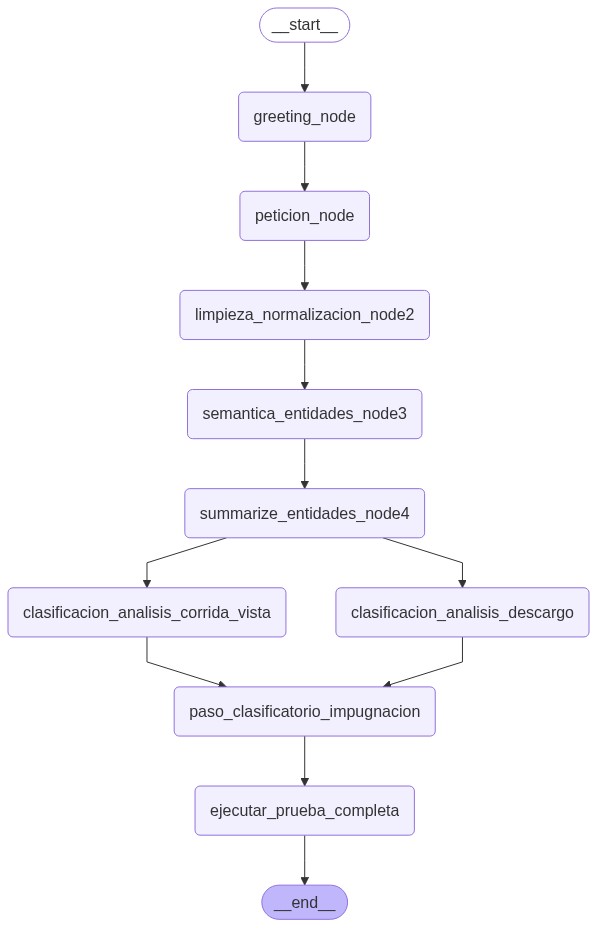

In [13]:
from IPython.display import Image, display

graph_compiled = graph.compile()

try:
    display(Image(graph_compiled.get_graph().draw_mermaid_png()))
except Exception:
    pass